# <font color='darkblue'>ASTR 21100 

# <font color='darkblue'>"Computational Techniques in Astrophysics"

## <font color='darkblue'>Instructor: Andrey Kravtsov

## <font color='darkblue'>Methods for finding minimum/maximum of a function (aka optimization)
## <font color='darkblue'>Part I, Derivative-free methods 

Optimization is numerical computations of the function parameter values, for which the function has minimum or maximum. 

Given that any maximum of $f(\mathbf{x})$ is a minimum of $-f(\mathbf{x})$, the actual methods focus on minimizing the function.

In [ ]:
import numpy as np 
from timeit import default_timer

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

# the following commands make plots look better
# try to experiment with these parameters to see what they do
dpi = 200
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [2., 2.]) # this makes lines plotted by plt.grid much nicer looking
#if you don't have LaTeX installed on your laptop and this statement 
# generates error, comment it out
plt.rc('text', usetex=True)

In [ ]:
# you don't need to review or understand this code
# this is a function for plotting 2d distribution of points as a histogram that will be used for plots below

import scipy.optimize as opt
from matplotlib.colors import LogNorm

def conf_interval(x, pdf, conf_level):
    return np.sum(pdf[pdf > x])-conf_level

def plot_2d_dist(x,y, xlim, ylim, nxbins, nybins, figsize=(5,5), 
                cmin=1.e-4, cmax=1.0, smooth=None, xpmax=None, ypmax=None, 
                log=False, weights=None, xlabel='x', ylabel='y', 
                clevs=None, fig_setup=None, savefig=None):
    """
    construct and plot a binned, 2d distribution in the x-y plane 
    using nxbins and nybins in x- and y- direction, respectively
    
    log = specifies whether logged quantities are passed to be plotted on log-scale outside this routine
    """
    if fig_setup is None:
        fig, ax = plt.subplots(figsize=figsize)
        plt.ylabel(ylabel)
        plt.xlabel(xlabel)
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
    else:
        ax = fig_setup
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xlim(xlim); ax.set_ylim(ylim)

    if xlim[1] < 0.: ax.invert_xaxis()

    if weights is None: weights = np.ones_like(x)
    H, xbins, ybins = np.histogram2d(x, y, weights=weights, bins=(np.linspace(xlim[0], xlim[1], nxbins),np.linspace(ylim[0], ylim[1], nybins)))
    
    H = np.rot90(H); H = np.flipud(H); 
             
    X,Y = np.meshgrid(xbins[:-1],ybins[:-1]) 

    if smooth != None:
        from scipy.signal import wiener
        H = wiener(H, mysize=smooth)
        
    H = H/np.sum(H)        
    Hmask = np.ma.masked_where(H==0,H)
    
    if log:
        X = np.power(10.,X); Y = np.power(10.,Y)

    pcol = ax.pcolormesh(X, Y,(Hmask), vmin=cmin*np.max(Hmask), vmax=cmax*np.max(Hmask), cmap=plt.cm.BuPu, norm = LogNorm(), linewidth=0., rasterized=True)
    pcol.set_edgecolor('face')
    
    # plot contours if contour levels are specified in clevs 
    if clevs is not None:
        lvls = []
        for cld in clevs:  
            sig = opt.brentq( conf_interval, 0., 1., args=(H,cld) )   
            lvls.append(sig)
        
        ax.contour(X, Y, H, linewidths=(1.0,0.75, 0.5, 0.25), colors='black', levels = sorted(lvls), 
                norm = LogNorm(), extent = [xbins[0], xbins[-1], ybins[0], ybins[-1]])
    if xpmax is not None:
        ax.scatter(xpmax, ypmax, marker='x', c='orangered', s=20)
    if savefig:
        plt.savefig(savefig,bbox_inches='tight')
    if fig_setup is None:
        plt.show()
    return


In [ ]:
def generate_mock_data(xlims, ex, ey, btrue=3, ctrue=3.481, nr = 2000):
    xr = np.random.uniform(xlims[0], xlims[1], size=nr) 

    exr = np.random.normal(scale=ex, size=nr)
    eyr = np.random.normal(scale=ey, size=nr)

    yr = btrue * xr + ctrue + eyr
    xr = xr + exr
    
    return xr, exr, yr, eyr

def plot_mock_data(xr, yr, exr=None, eyr=None, 
                   btrue=None, ctrue=None, figsize=(5,5)):
    # plot mock data
    plt.figure(figsize=figsize)
    plt.errorbar(xr, yr, xerr=exr, yerr=eyr, fmt='o', alpha=0.5, color='darkslateblue')
    plt.xlabel(r'x')
    plt.ylabel('y')
    xf = np.linspace(xr.min(), xr.max(), 10)
    plt.plot(xf, btrue * xf + ctrue, '--', c='orangered', label='true model')
    plt.legend(loc='best')
    plt.show()

def lnlinmodel_like(p, *args):
    """
    ln of linear model likelihood

    Parameters:
    -----------
    p - real 1d numpy vector of size 3 
        values of the model parameters, c, m, intrinsic scatter in y direction
    args is a list of numpy arrays in this order: 
        x - real 1d numpy vector
            x values of data, array size = number of data points ndata
        y - real 1d numpy vector
            y values of data of the same size as x 
        sigx - real 1d numpy vector of size x
            Gaussian st dev of x
        sigy - real 1d numpy vector of size 
            Gaussian st dev of y

    Returns:
    --------
    a real number 
        ln(Likelihood of linear model with intrinsic Gaussian scatter in y direction)
    """
    x, y, sigx, sigy = args
    sigtot2 = sigy**2 + (p[1]*sigx)**2
    
    # 1/sqrt(2.*pi) factor can be omitted from the likelihood because it does not depend on model parameters
    return np.sum(-0.5 * (np.log(sigtot2) + (y - p[0] - p[1]*x)**2 / sigtot2))
    


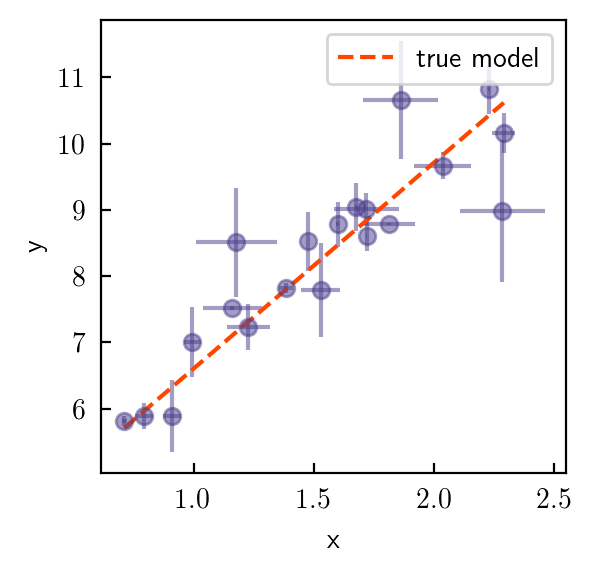

In [ ]:
# generate mock data with a given slope and intercept
nr = 20 # number of data points to generate
btrue, ctrue = 3.11, 3.5
ex, ey = 0.1, 0.5
xr, exr, yr, eyr = generate_mock_data([0.7, 2.5], ex, ey, btrue=btrue, ctrue=ctrue, nr=nr)

plot_mock_data(xr, yr, exr=exr, eyr=eyr, btrue=btrue, ctrue=ctrue, figsize=(3,3))

In [ ]:
ndim = 2
nsteps = 100000
x0 = [0.5, 0.5] # start at the true values of the parameters
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

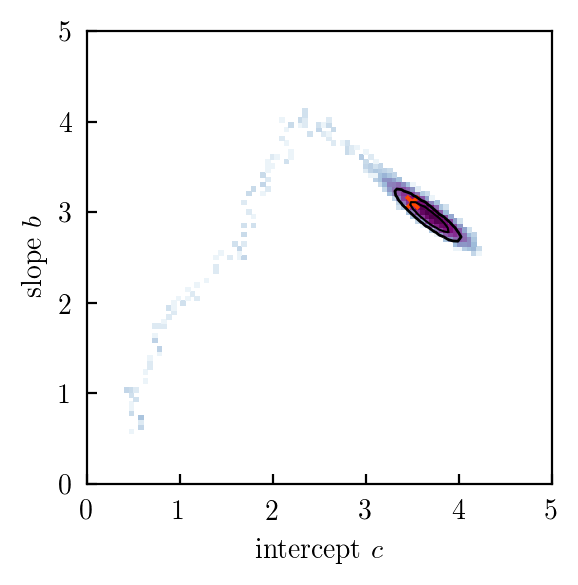

In [ ]:
conflevs = [0.6827, 0.9545]

plot_2d_dist(chain[:,0], chain[:,1], xlim=[0,5], ylim =[0,5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

### <font color='darkblue'>One of the simplest methods: Monte Carlo-based random walk minimization

Follows a random walk of a "*walker*" ($\mathbf{x}$ below is a vector of length $d$ - dimensionality of the parameter space where we are finding the minimum:

1. start at some initial point $\mathbf{x}=\mathbf{x}_0$. 

2. propose a step in a random direction $\mathbf{x}^\prime = \mathbf{x} + \Delta\mathbf{x}$

3. if $f(\mathbf{x}^\prime)< f(\mathbf{x})$, accept the step $\mathbf{x}=\mathbf{x}^\prime$, else go back to step 2.

Steps are terminated when some convergence is reached, for example no new step is accepted after some maximum number of proposed steps (it means that the walker is likely very close to the minimum), or accepted steps are smaller than some threshold. 


Choice of convergence criterion. Concept of ***the absolute tolerance*** parameter:

$$\mathtt{atol} > \max_{i=0,d-1}\vert x_i^\prime-x_i\vert$$ 

Components of the step vector $\Delta\mathbf{x}$ are usually chosen to follow Gaussian distribution, i.e. for a component $i$: 

$$p(\Delta x_i) = \frac{1}{\sqrt{2\pi}\,\sigma}\,\exp\left(-\frac{1}{2}\frac{\Delta x_i^2}{\sigma_i^2}\right) $$


The method requires choice of an optimal step sizes scale, $\sigma_i$. Performance and accuracy of the result will depend on this choice. However, this method is simple to implement, it does not require derivatives, and will do much better than the brute force search for a minimum. 

In [ ]:
def minimize_by_random_walk(func, x0, stepsize, *args, atol=1.e-6, verbose=True):
    assert(atol > 0.) # ensure abs tolerance is positive
    nd = np.shape(x0)[0] # number of parameters
    xold = x0 + 100.*atol # initialize old location just to get things started
    xnew = x0 # initial position
    step = stepsize # initial step size
    chain = []
    while np.abs(xnew - xold).max() > atol:
        xold = xnew
        fold = func(xold, *args)
        xtry = xold + np.random.normal(scale=step, size=nd) # generate a random Gaussian-distributed step
        while func(xtry, *args) >= fold:
            xtry = xold + np.random.normal(scale=step, size=nd)
        chain.append(xtry)
        xnew = xtry
        if verbose:
            print(xnew, np.abs(xnew - xold))

    return xnew, np.array(chain)

In [ ]:
def mlnlinmodel_min(x, *args):
    return -lnlinmodel_like(x, *args)

In [ ]:
x0 = np.array([0.5, 0.5])
args = [xr, yr, exr, eyr]

tstart = default_timer()
res, chain = minimize_by_random_walk(mlnlinmodel_min, x0, .025, *args, atol=5.e-4, verbose=False)

print("completed in %.3g sec"%(default_timer() - tstart))
print(res)

completed in 0.385 sec
[3.71233455 2.97029408]


In [ ]:
def plot_trace(x, figsize=3):
    try:
        nsteps, ndims = np.shape(x)[0], np.shape(x)[1]
    except:
        nsteps, ndims = np.shape(x)[0], 1
        
    plt.figure(figsize=(figsize,figsize))
    for d in range(ndims):
        if ndims == 1:
            plt.plot(np.arange(0,nsteps,1), x, lw=0.5,  label=r'$d={:d}$'.format(d))
        else:
            plt.plot(np.arange(0,nsteps), x[:,d], lw=0.5, label=r'$d={:d}$'.format(d))
    plt.ylabel(r'$x$') # label axis 
    plt.xlabel(r'step number')
    plt.legend(loc='best', frameon=False)
    plt.show()    

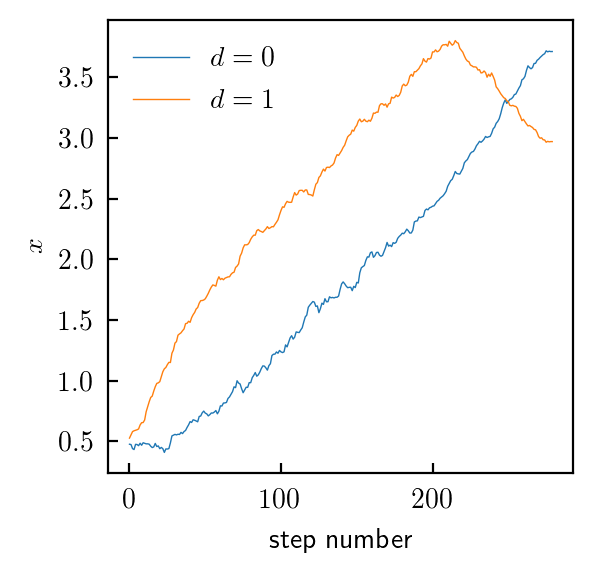

In [ ]:
plot_trace(chain)

In [ ]:
def mcmc_simple(x0, nsteps, step, logpdf, *args):
    """
    a simple implementation of the Metropolis MCMC algorithm
    implements steps using a uniformly distributed random number in the range [-step,step]

    Parameters:
    -----------
    x0:     1d numpy array of floats (size = number of dimensions), initial point
    nsteps: integer, the number of steps to make
    step:   float, step size normalization
    logpdf: Python function object for the ln(pdf) function
    args:   list, a list of arguments to pass to logpdf (can be empty)
    
    Returns:
    --------
    chain: list of size nsteps, containing all recorded steps 
    """
    x = x0 
    nparams = np.size(x0) # dimensionality of distribution we are sampling
    fnow = logpdf(x, *args) # compute current value of ln(pdf)
    
    chain = [] # initialize chain list
    for nstep in range(nsteps):
        xtry = x + step * np.random.uniform(-1, 1., size=nparams)
        ftry = logpdf(xtry, *args)
        if ftry > fnow:
            x = xtry
            fnow = ftry
        else: 
            u = np.log(np.random.uniform())
            if u < ftry-fnow:
                x = xtry
                fnow = ftry
        chain.append(x)
        
    return chain

In [ ]:
ndim = 2 # MCMC sampling of a 2-parameter linear model (intercept and slope)
nsteps = 100000
x0 = res
step = 0.1

args = [xr, yr, exr, eyr]
chain = np.asarray(mcmc_simple(x0, nsteps, step, loglin_like, *args))

conflevs = [0.6827, 0.9545]

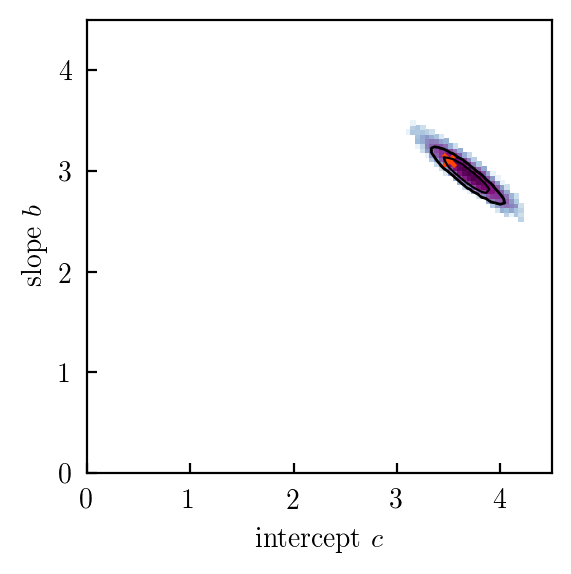

In [ ]:
plot_2d_dist(chain[:,0], chain[:,1], xlim=[0,4.5], ylim =[0,4.5], 
             nxbins=100, nybins=100, 
             clevs=conflevs, xpmax=ctrue, ypmax=btrue, 
             xlabel=r'${\rm intercept}\ c$', 
             ylabel=r'${\rm slope}\ b$', figsize=(3,3))

## <font color='darkblue'>In optimization ***function*** can be understood broadly and beyond the typical continuous algebraic functions we encounter in calculus and science. 


The two images are <tt>npix x npix</tt> arrays $x_1$ and $x_2$, while the right image is $x$ corresponding to the extremum of $f(x_1, x_2)$, where $f$ is some function quantifying differences or similarities of the two input images. 
<center>
<img width=1000 src="https://astro.uchicago.edu/~andrey/classes/a211/img/style_transfer.PNG"></img>

## <font color='darkblue'>Translation between languages can be thought of as a function

<center>
<img width=1000 src="https://astro.uchicago.edu/~andrey/classes/a211/img/translate_function1.PNG"></img>

## <font color='darkblue'>Translation between languages can be thought of as a function
that minimizes some measure of difference between phrases in two languages

<center>
<img width=1000 src="https://astro.uchicago.edu/~andrey/classes/a211/img/translate_function2.PNG"></img>

### <font color='darkblue'>An example: optimizing the Scav Road Trip
    
<p>
<center>
<img width=700 src="https://humanities-web.s3.us-east-2.amazonaws.com/college-prod/s3fs-public/styles/max_width_full/public/images/uniquely/IMG_0583.jpg?itok=qIz73XHV"></img>

### <font color='darkblue'>Optimizing the Scav Road Trip
    
UChicago Scavenger Hunt Roadtrip portion usually requires a road team to visit $n$ locations (within 1000 miles of Chicago) and collect some number of items at each.
    
The roadtrip lasts from Thursday morning to Saturday night, so needs to be completed in 60 hours but without violating speed limits and collecting as many items as possible.  
    
To optimize the road trip we want to find a route (order of locations to visit) that
    
* Starts and ends in the same location (Chicago).

* Visits each location exactly once (except the starting location twice).

* Minimizes the total time travelled.

In [ ]:
def init_distance_matrix(nlocations=15, dmax=1000.):
    # fill upper triangle of the matrix of distances between locations 
    # of shape (nlocations,nlocations) with randomly distributed distances from 0 to dmax miles
    distances = np.triu(np.random.uniform(0., dmax, size=nlocations**2).reshape((nlocations, nlocations)))
    # fill lower triangle of the matrix with symmetric distances and zero diagonal elements
    # diagonal elements are distances from a location to itself
    return distances + distances.T - 2.*np.diag(np.diag(distances))

In [ ]:
def matprint(mat, fmt="g"):
    """
    pretty print square matrix mat
    courtesy of https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75
    """
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")


In [ ]:
nloc = 8
dmat = init_distance_matrix(nlocations=nloc+1, dmax=1000.)

In [ ]:
matprint(dmat, fmt='.0f') # print distance matrix 

  0  608  466  714  284  420  766  794  841  
608    0  112  932  389  129  313   86  920  
466  112    0  272  212  892  424  459  628  
714  932  272    0  581  666  504  817  748  
284  389  212  581    0  879  445  747  832  
420  129  892  666  879    0  209  489  662  
766  313  424  504  445  209    0  231   95  
794   86  459  817  747  489  231    0   92  
841  920  628  748  832  662   95   92    0  


In [ ]:
def route_distance(route, dmatrix):
    d = 0. 
    for i, idest in enumerate(route[:-1]):
        d += dmatrix[idest,route[i+1]]
    return d

In [ ]:
route = np.zeros((nloc+2)).astype(int)
route[1:-1] = np.random.permutation(np.arange(1,nloc+1,1))
print("a random route for these locations:", route, route_distance(route, dmat))

a random route for these locations: [0 1 6 8 4 5 2 7 3 0] 5608.587124536744


In [ ]:
np.math.factorial(13)

6227020800

In [ ]:
# brute-force scan of all possible routes to find the shortest one
from itertools import permutations

dbest = 1e6
for i, p in enumerate(permutations(route[1:-1])):
    current_route = np.zeros_like(route)
    current_route[1:-1] = p # permute only locations other than start/end location
    d = route_distance(current_route, dmat) # compute total length of the route permutation given the 
    if d < dbest: 
        dbest = d
        best_route = np.copy(current_route)
    print(i, dbest, best_route)

0 5608.587124536744 [0 1 6 8 4 5 2 7 3 0]
1 5502.355588577747 [0 1 6 8 4 5 2 3 7 0]
2 4660.689986319566 [0 1 6 8 4 5 7 2 3 0]
3 4660.689986319566 [0 1 6 8 4 5 7 2 3 0]
4 4660.689986319566 [0 1 6 8 4 5 7 2 3 0]
5 4660.689986319566 [0 1 6 8 4 5 7 2 3 0]
6 4660.689986319566 [0 1 6 8 4 5 7 2 3 0]
7 4660.689986319566 [0 1 6 8 4 5 7 2 3 0]
8 4387.200036468277 [0 1 6 8 4 2 7 5 3 0]
9 4387.200036468277 [0 1 6 8 4 2 7 5 3 0]
10 4280.96850050928 [0 1 6 8 4 2 3 5 7 0]
11 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
12 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
13 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
14 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
15 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
16 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
17 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
18 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
19 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
20 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
21 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
22 4057.6416674213533 [0 1 6 8 4 2 3 7 5 0]
23 4057.64

201 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
202 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
203 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
204 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
205 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
206 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
207 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
208 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
209 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
210 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
211 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
212 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
213 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
214 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
215 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
216 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
217 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
218 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
219 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
220 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
221 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
222 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
223 3030.979124590146 [0 1 6 8 7

392 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
393 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
394 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
395 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
396 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
397 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
398 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
399 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
400 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
401 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
402 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
403 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
404 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
405 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
406 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
407 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
408 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
409 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
410 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
411 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
412 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
413 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
414 3030.979124590146 [0 1 6 8 7

678 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
679 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
680 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
681 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
682 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
683 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
684 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
685 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
686 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
687 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
688 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
689 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
690 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
691 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
692 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
693 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
694 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
695 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
696 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
697 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
698 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
699 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
700 3030.979124590146 [0 1 6 8 7

892 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
893 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
894 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
895 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
896 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
897 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
898 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
899 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
900 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
901 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
902 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
903 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
904 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
905 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
906 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
907 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
908 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
909 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
910 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
911 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
912 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
913 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
914 3030.979124590146 [0 1 6 8 7

1172 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1173 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1174 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1175 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1176 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1177 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1178 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1179 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1180 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1181 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1182 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1183 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1184 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1185 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1186 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1187 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1188 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1189 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1190 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1191 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1192 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1193 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1194 3030.

1451 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1452 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1453 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1454 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1455 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1456 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1457 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1458 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1459 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1460 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1461 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1462 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1463 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1464 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1465 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1466 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1467 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1468 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1469 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1470 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1471 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1472 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1473 3030.

1722 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1723 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1724 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1725 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1726 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1727 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1728 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1729 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1730 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1731 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1732 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1733 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1734 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1735 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1736 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1737 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1738 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1739 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1740 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1741 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1742 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1743 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1744 3030.

1915 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1916 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1917 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1918 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1919 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1920 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1921 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1922 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1923 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1924 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1925 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1926 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1927 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1928 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1929 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1930 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1931 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1932 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1933 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1934 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1935 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1936 3030.979124590146 [0 1 6 8 7 5 3 2 4 0]
1937 3030.

2246 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2247 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2248 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2249 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2250 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2251 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2252 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2253 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2254 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2255 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2256 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2257 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2258 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2259 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2260 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2261 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2262 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2263 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2264 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2265 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2266 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2267 2718.0620347350255 [0 1 5 6 8

2449 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2450 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2451 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2452 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2453 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2454 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2455 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2456 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2457 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2458 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2459 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2460 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2461 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2462 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2463 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2464 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2465 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2466 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2467 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2468 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2469 2718.0620347350255 [0 1 5 6 8 7 3 2 4 0]
2470 2718.0620347350255 [0 1 5 6 8

2717 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2718 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2719 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2720 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2721 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2722 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2723 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2724 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2725 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2726 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2727 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2728 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2729 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2730 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2731 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2732 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2733 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2734 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2735 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2736 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2737 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2738 2684.6339679770413 [0 1 5 7 8

2949 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2950 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2951 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2952 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2953 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2954 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2955 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2956 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2957 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2958 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2959 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2960 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2961 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2962 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2963 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2964 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2965 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2966 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2967 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2968 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2969 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
2970 2684.6339679770413 [0 1 5 7 8

3263 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3264 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3265 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3266 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3267 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3268 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3269 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3270 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3271 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3272 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3273 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3274 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3275 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3276 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3277 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3278 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3279 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3280 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3281 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3282 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3283 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3284 2684.6339679770413 [0 1 5 7 8

3456 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3457 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3458 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3459 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3460 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3461 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3462 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3463 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3464 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3465 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3466 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3467 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3468 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3469 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3470 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3471 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3472 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3473 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3474 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3475 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3476 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3477 2684.6339679770413 [0 1 5 7 8

3701 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3702 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3703 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3704 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3705 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3706 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3707 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3708 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3709 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3710 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3711 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3712 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3713 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3714 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3715 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3716 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3717 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3718 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3719 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3720 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3721 2684.6339679770413 [0 1 5 7 8 6 3 2 4 0]
3722 2684.6339679770413 [0 1 5 7 8

3892 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3893 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3894 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3895 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3896 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3897 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3898 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3899 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3900 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3901 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3902 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3903 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3904 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3905 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3906 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3907 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3908 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3909 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3910 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3911 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3912 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3913 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
3914 2524.

4127 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4128 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4129 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4130 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4131 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4132 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4133 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4134 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4135 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4136 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4137 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4138 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4139 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4140 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4141 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4142 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4143 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4144 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4145 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4146 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4147 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4148 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4149 2524.

4409 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4410 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4411 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4412 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4413 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4414 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4415 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4416 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4417 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4418 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4419 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4420 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4421 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4422 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4423 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4424 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4425 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4426 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4427 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4428 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4429 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4430 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4431 2524.

4630 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4631 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4632 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4633 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4634 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4635 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4636 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4637 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4638 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4639 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4640 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4641 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4642 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4643 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4644 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4645 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4646 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4647 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4648 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4649 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4650 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4651 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4652 2524.

4844 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4845 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4846 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4847 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4848 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4849 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4850 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4851 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4852 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4853 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4854 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4855 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4856 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4857 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4858 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4859 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4860 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4861 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4862 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4863 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4864 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4865 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
4866 2524.

5037 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5038 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5039 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5040 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5041 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5042 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5043 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5044 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5045 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5046 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5047 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5048 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5049 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5050 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5051 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5052 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5053 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5054 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5055 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5056 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5057 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5058 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5059 2524.

5313 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5314 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5315 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5316 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5317 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5318 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5319 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5320 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5321 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5322 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5323 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5324 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5325 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5326 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5327 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5328 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5329 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5330 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5331 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5332 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5333 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5334 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5335 2524.

5533 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5534 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5535 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5536 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5537 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5538 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5539 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5540 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5541 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5542 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5543 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5544 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5545 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5546 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5547 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5548 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5549 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5550 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5551 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5552 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5553 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5554 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5555 2524.

5762 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5763 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5764 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5765 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5766 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5767 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5768 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5769 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5770 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5771 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5772 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5773 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5774 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5775 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5776 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5777 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5778 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5779 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5780 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5781 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5782 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5783 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5784 2524.

5959 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5960 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5961 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5962 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5963 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5964 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5965 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5966 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5967 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5968 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5969 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5970 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5971 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5972 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5973 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5974 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5975 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5976 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5977 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5978 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5979 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5980 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
5981 2524.

6270 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6271 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6272 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6273 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6274 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6275 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6276 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6277 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6278 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6279 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6280 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6281 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6282 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6283 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6284 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6285 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6286 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6287 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6288 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6289 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6290 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6291 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6292 2524.

6489 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6490 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6491 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6492 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6493 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6494 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6495 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6496 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6497 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6498 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6499 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6500 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6501 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6502 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6503 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6504 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6505 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6506 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6507 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6508 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6509 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6510 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6511 2524.

6785 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6786 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6787 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6788 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6789 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6790 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6791 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6792 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6793 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6794 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6795 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6796 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6797 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6798 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6799 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6800 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6801 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6802 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6803 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6804 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6805 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6806 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
6807 2524.

7021 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7022 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7023 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7024 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7025 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7026 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7027 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7028 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7029 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7030 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7031 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7032 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7033 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7034 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7035 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7036 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7037 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7038 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7039 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7040 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7041 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7042 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7043 2524.

7301 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7302 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7303 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7304 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7305 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7306 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7307 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7308 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7309 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7310 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7311 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7312 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7313 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7314 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7315 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7316 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7317 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7318 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7319 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7320 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7321 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7322 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7323 2524.

7548 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7549 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7550 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7551 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7552 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7553 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7554 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7555 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7556 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7557 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7558 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7559 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7560 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7561 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7562 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7563 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7564 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7565 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7566 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7567 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7568 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7569 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7570 2524.

7743 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7744 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7745 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7746 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7747 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7748 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7749 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7750 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7751 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7752 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7753 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7754 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7755 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7756 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7757 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7758 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7759 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7760 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7761 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7762 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7763 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7764 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7765 2524.

7942 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7943 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7944 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7945 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7946 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7947 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7948 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7949 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7950 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7951 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7952 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7953 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7954 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7955 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7956 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7957 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7958 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7959 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7960 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7961 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7962 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7963 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
7964 2524.

8224 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8225 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8226 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8227 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8228 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8229 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8230 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8231 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8232 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8233 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8234 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8235 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8236 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8237 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8238 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8239 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8240 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8241 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8242 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8243 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8244 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8245 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8246 2524.

8466 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8467 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8468 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8469 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8470 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8471 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8472 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8473 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8474 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8475 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8476 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8477 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8478 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8479 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8480 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8481 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8482 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8483 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8484 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8485 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8486 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8487 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8488 2524.

8739 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8740 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8741 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8742 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8743 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8744 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8745 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8746 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8747 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8748 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8749 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8750 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8751 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8752 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8753 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8754 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8755 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8756 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8757 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8758 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8759 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8760 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8761 2524.

8943 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8944 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8945 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8946 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8947 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8948 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8949 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8950 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8951 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8952 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8953 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8954 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8955 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8956 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8957 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8958 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8959 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8960 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8961 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8962 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8963 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8964 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
8965 2524.

9206 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9207 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9208 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9209 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9210 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9211 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9212 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9213 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9214 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9215 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9216 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9217 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9218 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9219 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9220 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9221 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9222 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9223 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9224 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9225 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9226 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9227 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9228 2524.

9448 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9449 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9450 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9451 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9452 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9453 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9454 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9455 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9456 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9457 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9458 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9459 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9460 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9461 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9462 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9463 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9464 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9465 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9466 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9467 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9468 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9469 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9470 2524.

9673 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9674 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9675 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9676 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9677 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9678 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9679 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9680 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9681 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9682 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9683 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9684 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9685 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9686 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9687 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9688 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9689 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9690 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9691 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9692 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9693 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9694 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9695 2524.

9899 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9900 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9901 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9902 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9903 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9904 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9905 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9906 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9907 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9908 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9909 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9910 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9911 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9912 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9913 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9914 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9915 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9916 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9917 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9918 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9919 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9920 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
9921 2524.

10104 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10105 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10106 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10107 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10108 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10109 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10110 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10111 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10112 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10113 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10114 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10115 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10116 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10117 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10118 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10119 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10120 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10121 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10122 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10123 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10124 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10125 2524.476504516604 [0 1 7 8 6

10391 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10392 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10393 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10394 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10395 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10396 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10397 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10398 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10399 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10400 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10401 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10402 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10403 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10404 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10405 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10406 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10407 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10408 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10409 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10410 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10411 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10412 2524.476504516604 [0 1 7 8 6

10599 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10600 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10601 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10602 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10603 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10604 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10605 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10606 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10607 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10608 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10609 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10610 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10611 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10612 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10613 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10614 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10615 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10616 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10617 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10618 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10619 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10620 2524.476504516604 [0 1 7 8 6

10779 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10780 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10781 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10782 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10783 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10784 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10785 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10786 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10787 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10788 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10789 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10790 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10791 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10792 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10793 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10794 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10795 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10796 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10797 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10798 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10799 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
10800 2524.476504516604 [0 1 7 8 6

11073 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11074 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11075 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11076 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11077 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11078 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11079 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11080 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11081 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11082 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11083 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11084 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11085 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11086 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11087 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11088 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11089 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11090 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11091 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11092 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11093 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11094 2524.476504516604 [0 1 7 8 6

11269 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11270 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11271 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11272 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11273 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11274 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11275 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11276 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11277 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11278 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11279 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11280 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11281 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11282 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11283 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11284 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11285 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11286 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11287 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11288 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11289 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11290 2524.476504516604 [0 1 7 8 6

11540 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11541 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11542 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11543 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11544 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11545 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11546 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11547 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11548 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11549 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11550 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11551 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11552 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11553 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11554 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11555 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11556 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11557 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11558 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11559 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11560 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11561 2524.476504516604 [0 1 7 8 6

11789 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11790 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11791 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11792 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11793 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11794 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11795 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11796 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11797 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11798 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11799 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11800 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11801 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11802 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11803 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11804 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11805 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11806 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11807 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11808 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11809 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11810 2524.476504516604 [0 1 7 8 6

11979 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11980 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11981 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11982 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11983 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11984 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11985 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11986 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11987 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11988 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11989 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11990 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11991 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11992 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11993 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11994 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11995 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11996 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11997 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11998 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
11999 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12000 2524.476504516604 [0 1 7 8 6

12177 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12178 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12179 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12180 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12181 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12182 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12183 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12184 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12185 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12186 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12187 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12188 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12189 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12190 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12191 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12192 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12193 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12194 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12195 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12196 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12197 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12198 2524.476504516604 [0 1 7 8 6

12499 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12500 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12501 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12502 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12503 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12504 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12505 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12506 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12507 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12508 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12509 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12510 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12511 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12512 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12513 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12514 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12515 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12516 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12517 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12518 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12519 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12520 2524.476504516604 [0 1 7 8 6

12791 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12792 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12793 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12794 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12795 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12796 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12797 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12798 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12799 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12800 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12801 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12802 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12803 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12804 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12805 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12806 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12807 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12808 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12809 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12810 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12811 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12812 2524.476504516604 [0 1 7 8 6

12978 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12979 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12980 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12981 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12982 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12983 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12984 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12985 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12986 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12987 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12988 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12989 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12990 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12991 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12992 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12993 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12994 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12995 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12996 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12997 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12998 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
12999 2524.476504516604 [0 1 7 8 6

13233 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13234 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13235 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13236 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13237 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13238 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13239 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13240 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13241 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13242 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13243 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13244 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13245 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13246 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13247 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13248 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13249 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13250 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13251 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13252 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13253 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13254 2524.476504516604 [0 1 7 8 6

13513 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13514 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13515 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13516 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13517 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13518 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13519 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13520 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13521 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13522 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13523 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13524 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13525 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13526 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13527 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13528 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13529 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13530 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13531 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13532 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13533 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13534 2524.476504516604 [0 1 7 8 6

13713 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13714 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13715 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13716 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13717 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13718 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13719 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13720 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13721 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13722 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13723 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13724 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13725 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13726 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13727 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13728 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13729 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13730 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13731 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13732 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13733 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13734 2524.476504516604 [0 1 7 8 6

13931 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13932 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13933 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13934 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13935 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13936 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13937 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13938 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13939 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13940 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13941 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13942 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13943 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13944 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13945 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13946 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13947 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13948 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13949 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13950 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13951 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
13952 2524.476504516604 [0 1 7 8 6

14128 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14129 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14130 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14131 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14132 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14133 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14134 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14135 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14136 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14137 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14138 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14139 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14140 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14141 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14142 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14143 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14144 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14145 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14146 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14147 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14148 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14149 2524.476504516604 [0 1 7 8 6

14385 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14386 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14387 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14388 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14389 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14390 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14391 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14392 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14393 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14394 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14395 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14396 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14397 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14398 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14399 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14400 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14401 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14402 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14403 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14404 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14405 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14406 2524.476504516604 [0 1 7 8 6

14624 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14625 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14626 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14627 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14628 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14629 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14630 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14631 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14632 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14633 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14634 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14635 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14636 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14637 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14638 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14639 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14640 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14641 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14642 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14643 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14644 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14645 2524.476504516604 [0 1 7 8 6

14836 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14837 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14838 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14839 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14840 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14841 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14842 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14843 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14844 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14845 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14846 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14847 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14848 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14849 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14850 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14851 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14852 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14853 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14854 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14855 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14856 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
14857 2524.476504516604 [0 1 7 8 6

15094 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15095 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15096 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15097 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15098 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15099 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15100 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15101 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15102 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15103 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15104 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15105 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15106 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15107 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15108 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15109 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15110 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15111 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15112 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15113 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15114 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15115 2524.476504516604 [0 1 7 8 6

15357 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15358 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15359 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15360 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15361 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15362 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15363 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15364 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15365 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15366 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15367 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15368 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15369 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15370 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15371 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15372 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15373 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15374 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15375 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15376 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15377 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15378 2524.476504516604 [0 1 7 8 6

15603 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15604 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15605 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15606 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15607 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15608 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15609 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15610 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15611 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15612 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15613 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15614 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15615 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15616 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15617 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15618 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15619 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15620 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15621 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15622 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15623 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15624 2524.476504516604 [0 1 7 8 6

15801 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15802 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15803 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15804 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15805 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15806 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15807 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15808 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15809 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15810 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15811 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15812 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15813 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15814 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15815 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15816 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15817 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15818 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15819 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15820 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15821 2524.476504516604 [0 1 7 8 6 5 3 2 4 0]
15822 2524.476504516604 [0 1 7 8 6

16094 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16095 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16096 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16097 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16098 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16099 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16100 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16101 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16102 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16103 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16104 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16105 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16106 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16107 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16108 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16109 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16110 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16111 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16112 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16113 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16114 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16115 2472.63

16326 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16327 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16328 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16329 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16330 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16331 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16332 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16333 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16334 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16335 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16336 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16337 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16338 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16339 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16340 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16341 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16342 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16343 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16344 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16345 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16346 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16347 2472.63

16538 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16539 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16540 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16541 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16542 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16543 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16544 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16545 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16546 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16547 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16548 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16549 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16550 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16551 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16552 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16553 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16554 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16555 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16556 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16557 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16558 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16559 2472.63

16778 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16779 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16780 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16781 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16782 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16783 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16784 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16785 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16786 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16787 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16788 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16789 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16790 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16791 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16792 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16793 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16794 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16795 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16796 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16797 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16798 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
16799 2472.63

17060 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17061 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17062 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17063 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17064 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17065 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17066 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17067 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17068 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17069 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17070 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17071 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17072 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17073 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17074 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17075 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17076 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17077 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17078 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17079 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17080 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17081 2472.63

17263 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17264 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17265 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17266 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17267 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17268 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17269 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17270 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17271 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17272 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17273 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17274 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17275 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17276 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17277 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17278 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17279 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17280 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17281 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17282 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17283 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17284 2472.63

17477 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17478 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17479 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17480 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17481 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17482 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17483 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17484 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17485 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17486 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17487 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17488 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17489 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17490 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17491 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17492 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17493 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17494 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17495 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17496 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17497 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17498 2472.63

17683 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17684 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17685 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17686 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17687 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17688 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17689 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17690 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17691 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17692 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17693 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17694 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17695 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17696 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17697 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17698 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17699 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17700 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17701 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17702 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17703 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17704 2472.63

17888 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17889 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17890 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17891 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17892 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17893 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17894 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17895 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17896 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17897 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17898 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17899 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17900 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17901 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17902 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17903 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17904 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17905 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17906 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17907 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17908 2472.6351079854667 [0 4 6 8 7 1 2 3 5 0]
17909 2472.63

18141 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18142 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18143 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18144 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18145 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18146 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18147 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18148 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18149 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18150 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18151 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18152 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18153 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18154 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18155 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18156 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18157 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18158 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18159 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18160 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18161 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18162 2470.364125035608 [0 4 2 1 7

18350 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18351 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18352 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18353 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18354 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18355 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18356 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18357 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18358 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18359 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18360 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18361 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18362 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18363 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18364 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18365 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18366 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18367 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18368 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18369 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18370 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18371 2470.364125035608 [0 4 2 1 7

18622 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18623 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18624 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18625 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18626 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18627 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18628 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18629 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18630 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18631 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18632 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18633 2470.364125035608 [0 4 2 1 7 8 6 5 3 0]
18634 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18635 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18636 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18637 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18638 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18639 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18640 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18641 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18642 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18643 2093.5051275671385 

18858 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18859 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18860 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18861 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18862 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18863 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18864 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18865 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18866 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18867 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18868 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18869 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18870 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18871 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18872 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18873 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18874 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18875 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18876 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18877 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18878 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
18879 2093.50

19039 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19040 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19041 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19042 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19043 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19044 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19045 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19046 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19047 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19048 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19049 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19050 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19051 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19052 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19053 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19054 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19055 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19056 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19057 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19058 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19059 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19060 2093.50

19283 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19284 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19285 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19286 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19287 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19288 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19289 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19290 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19291 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19292 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19293 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19294 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19295 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19296 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19297 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19298 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19299 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19300 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19301 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19302 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19303 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19304 2093.50

19507 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19508 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19509 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19510 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19511 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19512 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19513 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19514 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19515 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19516 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19517 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19518 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19519 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19520 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19521 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19522 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19523 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19524 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19525 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19526 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19527 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19528 2093.50

19715 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19716 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19717 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19718 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19719 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19720 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19721 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19722 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19723 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19724 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19725 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19726 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19727 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19728 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19729 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19730 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19731 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19732 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19733 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19734 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19735 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19736 2093.50

19967 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19968 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19969 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19970 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19971 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19972 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19973 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19974 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19975 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19976 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19977 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19978 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19979 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19980 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19981 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19982 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19983 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19984 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19985 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19986 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19987 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
19988 2093.50

20243 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20244 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20245 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20246 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20247 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20248 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20249 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20250 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20251 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20252 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20253 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20254 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20255 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20256 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20257 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20258 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20259 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20260 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20261 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20262 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20263 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20264 2093.50

20500 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20501 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20502 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20503 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20504 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20505 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20506 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20507 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20508 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20509 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20510 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20511 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20512 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20513 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20514 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20515 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20516 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20517 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20518 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20519 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20520 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20521 2093.50

20690 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20691 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20692 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20693 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20694 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20695 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20696 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20711 2093.50

20890 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20891 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20892 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20893 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20894 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20895 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20896 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20897 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20898 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20899 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20900 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20901 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20902 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20903 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20904 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20905 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20906 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20907 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20908 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20909 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20910 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
20911 2093.50

21122 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21123 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21124 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21125 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21126 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21127 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21128 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21129 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21130 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21131 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21132 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21133 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21134 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21135 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21136 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21137 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21138 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21139 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21140 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21141 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21142 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21143 2093.50

21332 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21333 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21334 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21335 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21336 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21337 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21338 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21339 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21340 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21341 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21342 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21343 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21344 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21345 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21346 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21347 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21348 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21349 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21350 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21351 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21352 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21353 2093.50

21545 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21546 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21547 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21548 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21549 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21550 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21551 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21552 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21553 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21554 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21555 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21556 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21557 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21558 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21559 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21560 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21561 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21562 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21563 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21564 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21565 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21566 2093.50

21723 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21724 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21725 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21726 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21727 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21728 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21729 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21730 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21731 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21732 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21733 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21734 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21735 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21736 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21737 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21738 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21739 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21740 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21741 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21742 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21743 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21744 2093.50

21988 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21989 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21990 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21991 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21992 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21993 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21994 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21995 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21996 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21997 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21998 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
21999 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22000 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22001 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22002 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22003 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22004 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22005 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22006 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22007 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22008 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22009 2093.50

22207 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22208 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22209 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22210 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22211 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22212 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22213 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22214 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22215 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22216 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22217 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22218 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22219 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22220 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22221 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22222 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22223 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22224 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22225 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22226 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22227 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22228 2093.50

22449 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22450 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22451 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22452 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22453 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22454 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22455 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22456 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22457 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22458 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22459 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22460 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22461 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22462 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22463 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22464 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22465 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22466 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22467 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22468 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22469 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22470 2093.50

22713 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22714 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22715 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22716 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22717 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22718 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22719 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22720 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22721 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22722 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22723 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22724 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22725 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22726 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22727 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22728 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22729 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22730 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22731 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22732 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22733 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22734 2093.50

22937 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22938 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22939 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22940 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22941 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22942 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22943 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22944 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22945 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22946 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22947 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22948 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22949 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22950 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22951 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22952 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22953 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22954 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22955 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22956 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22957 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
22958 2093.50

23137 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23138 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23139 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23140 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23141 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23142 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23143 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23144 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23145 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23146 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23147 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23148 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23149 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23150 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23151 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23152 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23153 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23154 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23155 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23156 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23157 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23158 2093.50

23372 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23373 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23374 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23375 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23376 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23377 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23378 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23379 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23380 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23381 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23382 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23383 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23384 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23385 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23386 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23387 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23388 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23389 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23390 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23391 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23392 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23393 2093.50

23639 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23640 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23641 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23642 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23643 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23644 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23645 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23646 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23647 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23648 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23649 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23650 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23651 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23652 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23653 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23654 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23655 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23656 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23657 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23658 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23659 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23660 2093.50

23827 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23828 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23829 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23830 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23831 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23832 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23833 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23834 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23835 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23836 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23837 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23838 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23839 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23840 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23841 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23842 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23843 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23844 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23845 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23846 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23847 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
23848 2093.50

24004 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24005 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24006 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24007 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24008 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24009 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24010 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24011 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24012 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24013 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24014 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24015 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24016 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24017 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24018 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24019 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24020 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24021 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24022 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24023 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24024 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24025 2093.50

24204 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24205 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24206 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24207 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24208 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24209 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24210 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24211 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24212 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24213 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24214 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24215 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24216 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24217 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24218 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24219 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24220 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24221 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24222 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24223 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24224 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24225 2093.50

24488 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24489 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24490 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24491 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24492 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24493 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24494 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24495 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24496 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24497 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24498 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24499 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24500 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24501 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24502 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24503 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24504 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24505 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24506 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24507 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24508 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24509 2093.50

24748 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24749 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24750 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24751 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24752 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24753 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24754 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24755 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24756 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24757 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24758 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24759 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24760 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24761 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24762 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24763 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24764 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24765 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24766 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24767 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24768 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
24769 2093.50

25010 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25011 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25012 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25013 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25014 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25015 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25016 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25017 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25018 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25019 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25020 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25021 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25022 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25023 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25024 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25025 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25026 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25027 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25028 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25029 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25030 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25031 2093.50

25267 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25268 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25269 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25270 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25271 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25272 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25273 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25274 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25275 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25276 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25277 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25278 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25279 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25280 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25281 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25282 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25283 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25284 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25285 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25286 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25287 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25288 2093.50

25520 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25521 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25522 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25523 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25524 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25525 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25526 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25527 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25528 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25529 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25530 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25531 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25532 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25533 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25534 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25535 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25536 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25537 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25538 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25539 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25540 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25541 2093.50

25720 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25721 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25722 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25723 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25724 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25725 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25726 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25727 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25728 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25729 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25730 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25731 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25732 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25733 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25734 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25735 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25736 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25737 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25738 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25739 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25740 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25741 2093.50

25908 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25909 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25910 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25911 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25912 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25913 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25914 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25915 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25916 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25917 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25918 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25919 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25920 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25921 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25922 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25923 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25924 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25925 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25926 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25927 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25928 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
25929 2093.50

26129 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26130 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26131 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26132 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26133 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26134 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26135 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26136 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26137 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26138 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26139 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26140 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26141 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26142 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26143 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26144 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26145 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26146 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26147 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26148 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26149 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26150 2093.50

26394 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26395 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26396 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26397 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26398 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26399 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26400 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26401 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26402 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26403 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26404 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26405 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26406 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26407 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26408 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26409 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26410 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26411 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26412 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26413 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26414 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26415 2093.50

26658 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26659 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26660 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26661 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26662 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26663 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26664 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26665 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26666 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26667 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26668 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26669 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26670 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26671 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26672 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26673 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26674 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26675 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26676 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26677 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26678 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26679 2093.50

26911 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26912 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26913 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26914 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26915 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26916 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26917 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26918 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26919 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26920 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26921 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26922 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26923 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26924 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26925 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26926 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26927 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26928 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26929 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26930 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26931 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
26932 2093.50

27179 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27180 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27181 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27182 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27183 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27184 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27185 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27186 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27187 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27188 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27189 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27190 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27191 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27192 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27193 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27194 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27195 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27196 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27197 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27198 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27199 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27200 2093.50

27429 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27430 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27431 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27432 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27433 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27434 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27435 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27436 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27437 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27438 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27439 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27440 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27441 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27442 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27443 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27444 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27445 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27446 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27447 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27448 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27449 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27450 2093.50

27690 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27691 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27692 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27693 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27694 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27695 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27696 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27711 2093.50

27930 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27931 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27932 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27933 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27934 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27935 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27936 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27937 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27938 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27939 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27940 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27941 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27942 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27943 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27944 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27945 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27946 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27947 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27948 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27949 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27950 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
27951 2093.50

28227 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28228 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28229 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28230 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28231 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28232 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28233 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28234 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28235 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28236 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28237 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28238 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28239 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28240 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28241 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28242 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28243 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28244 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28245 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28246 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28247 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28248 2093.50

28486 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28487 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28488 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28489 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28490 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28491 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28492 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28493 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28494 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28495 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28496 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28497 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28498 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28499 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28500 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28501 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28502 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28503 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28504 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28505 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28506 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28507 2093.50

28698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28711 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28712 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28713 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28714 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28715 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28716 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28717 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28718 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28719 2093.50

28947 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28948 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28949 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28950 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28951 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28952 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28953 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28954 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28955 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28956 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28957 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28958 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28959 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28960 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28961 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28962 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28963 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28964 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28965 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28966 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28967 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
28968 2093.50

29227 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29228 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29229 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29230 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29231 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29232 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29233 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29234 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29235 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29236 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29237 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29238 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29239 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29240 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29241 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29242 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29243 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29244 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29245 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29246 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29247 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29248 2093.50

29430 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29431 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29432 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29433 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29434 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29435 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29436 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29437 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29438 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29439 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29440 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29441 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29442 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29443 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29444 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29445 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29446 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29447 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29448 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29449 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29450 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29451 2093.50

29685 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29686 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29687 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29688 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29689 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29690 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29691 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29692 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29693 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29694 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29695 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29696 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29706 2093.50

29907 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29908 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29909 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29910 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29911 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29912 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29913 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29914 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29915 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29916 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29917 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29918 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29919 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29920 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29921 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29922 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29923 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29924 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29925 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29926 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29927 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
29928 2093.50

30097 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30098 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30099 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30100 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30101 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30102 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30103 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30104 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30105 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30106 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30107 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30108 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30109 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30110 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30111 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30112 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30113 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30114 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30115 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30116 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30117 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30118 2093.50

30276 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30277 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30278 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30279 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30280 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30281 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30282 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30283 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30284 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30285 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30286 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30287 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30288 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30289 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30290 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30291 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30292 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30293 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30294 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30295 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30296 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30297 2093.50

30593 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30594 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30595 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30596 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30597 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30598 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30599 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30600 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30601 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30602 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30603 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30604 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30605 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30606 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30607 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30608 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30609 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30610 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30611 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30612 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30613 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30614 2093.50

30802 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30803 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30804 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30805 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30806 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30807 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30808 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30809 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30810 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30811 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30812 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30813 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30814 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30815 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30816 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30817 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30818 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30819 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30820 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30821 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30822 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
30823 2093.50

31014 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31015 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31016 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31017 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31018 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31019 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31020 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31021 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31022 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31023 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31024 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31025 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31026 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31027 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31028 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31029 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31030 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31031 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31032 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31033 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31034 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31035 2093.50

31275 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31276 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31277 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31278 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31279 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31280 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31281 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31282 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31283 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31284 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31285 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31286 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31287 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31288 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31289 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31290 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31291 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31292 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31293 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31294 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31295 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31296 2093.50

31557 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31558 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31559 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31560 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31561 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31562 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31563 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31564 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31565 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31566 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31567 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31568 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31569 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31570 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31571 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31572 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31573 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31574 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31575 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31576 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31577 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31578 2093.50

31767 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31768 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31769 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31770 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31771 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31772 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31773 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31774 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31775 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31776 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31777 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31778 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31779 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31780 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31781 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31782 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31783 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31784 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31785 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31786 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31787 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
31788 2093.50

32011 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32012 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32013 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32014 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32015 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32016 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32017 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32018 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32019 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32020 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32021 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32022 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32023 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32024 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32025 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32026 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32027 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32028 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32029 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32030 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32031 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32032 2093.50

32200 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32201 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32202 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32203 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32204 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32205 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32206 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32207 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32208 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32209 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32210 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32211 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32212 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32213 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32214 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32215 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32216 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32217 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32218 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32219 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32220 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32221 2093.50

32437 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32438 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32439 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32440 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32441 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32442 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32443 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32444 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32445 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32446 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32447 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32448 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32449 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32450 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32451 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32452 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32453 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32454 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32455 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32456 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32457 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32458 2093.50

32697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32711 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32712 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32713 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32714 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32715 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32716 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32717 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32718 2093.50

32912 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32913 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32914 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32915 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32916 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32917 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32918 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32919 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32920 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32921 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32922 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32923 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32924 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32925 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32926 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32927 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32928 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32929 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32930 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32931 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32932 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
32933 2093.50

33264 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33265 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33266 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33267 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33268 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33269 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33270 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33271 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33272 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33273 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33274 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33275 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33276 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33277 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33278 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33279 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33280 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33281 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33282 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33283 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33284 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33285 2093.50

33555 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33556 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33557 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33558 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33559 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33560 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33561 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33562 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33563 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33564 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33565 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33566 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33567 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33568 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33569 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33570 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33571 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33572 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33573 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33574 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33575 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33576 2093.50

33731 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33732 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33733 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33734 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33735 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33736 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33737 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33738 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33739 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33740 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33741 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33742 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33743 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33744 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33745 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33746 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33747 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33748 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33749 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33750 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33751 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33752 2093.50

33956 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33957 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33958 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33959 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33960 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33961 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33962 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33963 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33964 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33965 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33966 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33967 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33968 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33969 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33970 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33971 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33972 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33973 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33974 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33975 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33976 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
33977 2093.50

34169 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34170 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34171 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34172 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34173 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34174 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34175 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34176 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34177 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34178 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34179 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34180 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34181 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34182 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34183 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34184 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34185 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34186 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34187 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34188 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34189 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34190 2093.50

34403 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34404 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34405 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34406 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34407 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34408 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34409 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34410 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34411 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34412 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34413 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34414 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34415 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34416 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34417 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34418 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34419 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34420 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34421 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34422 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34423 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34424 2093.50

34667 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34668 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34669 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34670 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34671 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34672 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34673 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34674 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34675 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34676 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34677 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34678 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34679 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34680 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34681 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34682 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34683 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34684 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34685 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34686 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34687 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34688 2093.50

34897 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34898 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34899 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34900 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34901 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34902 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34903 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34904 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34905 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34906 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34907 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34908 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34909 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34910 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34911 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34912 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34913 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34914 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34915 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34916 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34917 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
34918 2093.50

35165 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35166 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35167 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35168 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35169 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35170 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35171 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35172 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35173 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35174 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35175 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35176 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35177 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35178 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35179 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35180 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35181 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35182 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35183 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35184 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35185 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35186 2093.50

35507 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35508 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35509 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35510 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35511 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35512 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35513 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35514 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35515 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35516 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35517 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35518 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35519 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35520 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35521 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35522 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35523 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35524 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35525 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35526 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35527 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35528 2093.50

35696 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35711 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35712 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35713 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35714 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35715 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35716 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35717 2093.50

35939 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35940 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35941 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35942 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35943 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35944 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35945 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35946 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35947 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35948 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35949 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35950 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35951 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35952 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35953 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35954 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35955 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35956 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35957 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35958 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35959 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
35960 2093.50

36149 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36150 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36151 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36152 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36153 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36154 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36155 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36156 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36157 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36158 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36159 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36160 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36161 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36162 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36163 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36164 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36165 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36166 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36167 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36168 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36169 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36170 2093.50

36398 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36399 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36400 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36401 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36402 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36403 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36404 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36405 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36406 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36407 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36408 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36409 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36410 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36411 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36412 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36413 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36414 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36415 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36416 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36417 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36418 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36419 2093.50

36696 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36711 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36712 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36713 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36714 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36715 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36716 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36717 2093.50

36969 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36970 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36971 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36972 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36973 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36974 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36975 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36976 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36977 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36978 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36979 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36980 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36981 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36982 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36983 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36984 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36985 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36986 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36987 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36988 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36989 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
36990 2093.50

37217 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37218 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37219 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37220 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37221 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37222 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37223 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37224 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37225 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37226 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37227 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37228 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37229 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37230 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37231 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37232 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37233 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37234 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37235 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37236 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37237 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37238 2093.50

37396 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37397 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37398 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37399 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37400 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37401 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37402 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37403 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37404 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37405 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37406 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37407 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37408 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37409 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37410 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37411 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37412 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37413 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37414 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37415 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37416 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37417 2093.50

37606 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37607 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37608 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37609 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37610 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37611 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37612 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37613 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37614 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37615 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37616 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37617 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37618 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37619 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37620 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37621 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37622 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37623 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37624 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37625 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37626 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37627 2093.50

37787 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37788 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37789 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37790 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37791 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37792 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37793 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37794 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37795 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37796 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37797 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37798 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37799 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37800 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37801 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37802 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37803 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37804 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37805 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37806 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37807 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37808 2093.50

37980 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37981 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37982 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37983 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37984 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37985 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37986 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37987 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37988 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37989 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37990 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37991 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37992 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37993 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37994 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37995 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37996 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37997 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37998 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
37999 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38000 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38001 2093.50

38265 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38266 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38267 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38268 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38269 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38270 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38271 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38272 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38273 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38274 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38275 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38276 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38277 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38278 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38279 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38280 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38281 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38282 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38283 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38284 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38285 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38286 2093.50

38460 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38461 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38462 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38463 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38464 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38465 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38466 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38467 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38468 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38469 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38470 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38471 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38472 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38473 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38474 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38475 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38476 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38477 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38478 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38479 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38480 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38481 2093.50

38662 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38663 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38664 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38665 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38666 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38667 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38668 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38669 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38670 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38671 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38672 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38673 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38674 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38675 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38676 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38677 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38678 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38679 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38680 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38681 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38682 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38683 2093.50

38911 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38912 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38913 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38914 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38915 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38916 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38917 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38918 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38919 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38920 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38921 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38922 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38923 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38924 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38925 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38926 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38927 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38928 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38929 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38930 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38931 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
38932 2093.50

39216 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39217 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39218 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39219 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39220 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39221 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39222 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39223 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39224 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39225 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39226 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39227 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39228 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39229 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39230 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39231 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39232 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39233 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39234 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39235 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39236 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39237 2093.50

39442 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39443 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39444 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39445 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39446 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39447 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39448 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39449 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39450 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39451 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39452 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39453 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39454 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39455 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39456 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39457 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39458 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39459 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39460 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39461 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39462 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39463 2093.50

39690 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39691 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39692 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39693 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39694 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39695 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39696 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39697 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39698 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39699 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39700 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39701 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39702 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39703 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39704 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39705 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39706 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39707 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39708 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39709 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39710 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39711 2093.50

39955 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39956 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39957 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39958 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39959 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39960 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39961 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39962 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39963 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39964 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39965 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39966 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39967 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39968 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39969 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39970 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39971 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39972 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39973 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39974 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39975 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
39976 2093.50

40135 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40136 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40137 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40138 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40139 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40140 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40141 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40142 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40143 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40144 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40145 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40146 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40147 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40148 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40149 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40150 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40151 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40152 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40153 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40154 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40155 2093.5051275671385 [0 4 2 3 6 8 7 1 5 0]
40156 2093.50

### <font color='darkblue'>Monte Carlo algorithm for optimization of the length of the Scav Road Trip

* Start with a random choice for the order of destinations with total length $L$
    
* Propose a new route and compute its length $L^\prime$. 
    
* Accept proposed route if it is shorter $\Delta = L^\prime - L<0$ or if $\mathrm{uniform}(0,1)<e^{-\Delta/S}$, where $S$ is a parameter of order of maximum distance from the origin to a destination (i.e. $\sim 1000$ miles in this problem).
   

In [ ]:
def optimize_road_trip_by_random_walk(dmatrix=None, s=100, 
                                      nmaxsteps=1000, nout=0):
    assert(np.shape(dmatrix)[0] == np.shape(dmatrix)[1])
    nloc = np.shape(dmatrix)[0] - 1
    # initialize route that starts at 0 (Chicago) and ends at 0
    route = np.zeros((nloc+2)).astype(int)
    route[1:-1] = np.random.permutation(np.arange(1,nloc+1,1))
    dold, dbest = route_distance(route, dmatrix), 1e6
    chain, nbest = [], 0 
    for nstep in range(nmaxsteps):
        rtry = np.copy(route)
        # code for a new route proposal here
        irand = np.random.randint(1, nloc, size=1)
        if irand != nloc: inext = irand + 1 # pick next location in the current route
        else: inext=1  # 
        # swap these two successive destinations to form a new trial route
        rtry = np.copy(route)
        rtry[irand], rtry[inext] = rtry[inext], rtry[irand]

        dnew = route_distance(rtry, dmatrix) # compute length of the trial route
        delta = dnew - dold # difference of length from the current route
        u = np.log(np.random.uniform(size=1))
        
        if delta<0 or u < -delta/s:
            route = np.copy(rtry)
            dold = dnew
            if dnew < dbest:
                best_route = np.copy(route)
                nbest, dbest = nstep, dnew
        if nout and not nstep % nout:
            print(nstep, route, dbest)
    print("found optimal route of length {:.0f} miles after {:d} steps".format(dbest, nbest))
    return dbest, best_route

In [ ]:
optimize_road_trip_by_random_walk(dmatrix=dmat, s=1000, nmaxsteps=10000)

found optimal route of length 2094 miles after 1859 steps


(2093.5051275671385, array([0, 5, 1, 7, 8, 6, 3, 2, 4, 0]))

### <font color='darkblue'>Note that the function here is discontinuous

Many optimization methods are based on function derivatives to find direction to the minimum. However, for functions like these derivatives are not defined and there are many functions for which derivatives are difficult to estimate. 
    
Hence, there is a need for ***derivative-free*** optimization methods. Random walk is one of them (today we are focusing only on derivative-free methods). 

### <font color='darkblue'>Local minima vs global minimum 

<p>
<center>
<a href="http://nelder-mead.s3-website.us-east-2.amazonaws.com/"><img width=700 src="https://astro.uchicago.edu/~andrey/classes/a211/img/local_vs_global_min.PNG"></img></a>

### <font color='darkblue'>Other considerations for the optimization methods
    
* Global minimization (find all minima) vs local minimization (find local minimum only)    
    
* Computational efficiency

* Robustness of the result: whether true minimum is found regardless of the starting guess
    
* Whether it is easy to impose boundaries on the values of the function parameters during minimum search


### <font color='darkblue'>A test case: sampling of the Rosenbrock "banana" distribution

Rosenbrock distribution is described by the following equation in 2D (i.e. for two parameters $x$ and $y$): 

$$p_{\rm R}(x_1,x_2) = \exp\left[-c(b(x_2-x_1^2)^2 -(a-x_1)^2)\right], $$
    

which is often used for testing optimization and sampling algorithms, particularly with $a=1$, $b=100$ most often used. It has a global maximum at $(x_1,x_2)=(a,a^2)$ at which $p_{\rm R}(x_1,x_2)=1$, as is clear from the equation above. 

The multi-dimensional extension of the Rosenbrock function for $d$-dimensional space of parameters $\mathbf{x}=\{x_0,x_1.\ldots,x_{d-1}\}$ is

$$p_{\rm R}(\vec{x}\vert a, b,c)=\exp\left(-c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]\right).$$

or

$$\ln p_{\rm R}(\vec{x}\vert a, b,c) = -c\times \sum\limits_{i=1}^{d-1}\left[b(x_{i}-x_{i-1}^2)^2 + (a-x_{i-1})^2\right]$$

This function is frequently used for testing of sampling and optimization algorithms (we will discuss these next week) because this function is quite "difficult" despite its benign-looking functional form. The function spans a wide range of values over small change of parameters: it has a strongly "curved" ridge in the $x-y$ plane which extends  values to large values of $x$ and $y$. 

The function is named after Howard H. Rosenbrock, who introduced it as a test case for a minimization algorithm he developed in a <a href="https://academic.oup.com/comjnl/article/3/3/175/345501">paper</a> in 1960. 

Note that $-r(\mathbf{x})$ will be a function with a long curved "ridge" instead of "valley". Such function is often used in testing sampling algorithm and we will see it again when we talk about MCMC sampling. 

The routine below that was taken from the SciPy optimize package tutorials uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions. Below we will use this function as a test case to find its minimum for 2D and 5D cases.    

The function below computes $\ln p_{\rm R}(\vec{x})$ and uses Python's vector slicing to calculate the function for $a=1$, $b=100$. Note that this implementation does not explicitly deal with dimensionality of the input vector $\mathbf{x}$, this is done automatically using NumPy vector operations. Thus, the same code works for $\mathbf{x}$ of different dimensions.    

In [ ]:
def mlnrosenbrock(x, a=1., b=100., c=1.):
    """-\ln of the Rosenbrock "banana" distribution
    x is a numpy vector of points in 2 or more dimensional space
    """
    return c * sum(b*(x[1:]-x[:-1]**2.0)**2.0 + (a-x[:-1])**2.0)

In [ ]:
# define a grid of x and y for calculations and plotting
xmin, xmax, ng = -10, 10, 100
ymin, ymax = -50, 100
x = np.linspace(xmin, xmax, ng)
y = np.linspace(ymin, ymax, ng)

# generate a 2d grid of x and y points
xg, yg = np.meshgrid(x, y)

# form a single array of 2D vectors 
x = np.vstack([xg.ravel(), yg.ravel()])

# compute the Rosenbrock function and reshape the output into ng x ng grid for plotting
rg = mlnrosenbrock(x).reshape((ng,ng))


In [ ]:
from matplotlib import cm

def plot_color_map(x, y, data, xlim=[0.,1], ylim=[0.,1.], 
                   xlabel = ' ', ylabel = ' ', cmap='winter', colorbar=None, 
                   contours = False, levels = [], contcmap = 'winter',
                   plot_title=None, figsize=3.0, figsave=None):
    """
    Helper function to plot colormaps of a 2d array of values with or without contours
    
    Parameters:
    -----------
    x, y - 1d numpy vectors generated by numpy.meshgrid functions
    data - 2d numpy array, containing data values at the grid represented by x and y
    xlim, ylim - lists of size 2 containing limits for x and y axes
    cmap: string, Matplotlib colormap to use
    colormap: boolean, if True plot colorbar
    contours: boolean, if True plot contours corresponding to data levels specified by levels parameter
    levels: values of data for which to draw contour levels
    contcmap: string, Matplotlib colormap to use for contour lines 
    plot_title: string, if not None will be used to prouce plot title at the top
    figsize: float, size of Matplotlib figure
    figsave: None or string, if string, the string will be used as a path/filename to save PDF of the plot
    
    Returns:
    --------
    Nothing
    
    """
    
    fig, ax = plt.subplots(figsize=(figsize,figsize))
    ax.axis([xlim[0], xlim[1], ylim[0], ylim[1]])

    plt.xlabel(xlabel); plt.ylabel(ylabel)
    cmap = cm.get_cmap(cmap)
    im = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=False)
    if contours:
        ax.contour(x, y, data, levels=levels, cmap=contcmap)
    if colorbar: 
        fig.colorbar(im, ax=ax)
    if plot_title:
        plt.title(plot_title, fontsize=3.*figsize)

    if figsave:
        plt.savefig(figsave, bbox_inches='tight')
    plt.show()


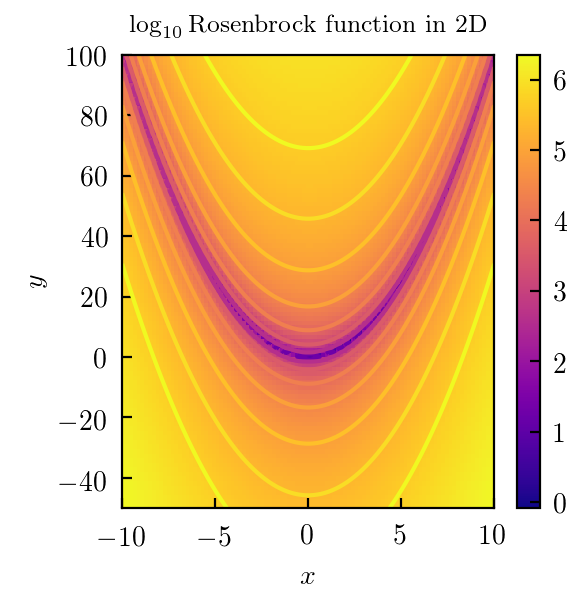

In [ ]:
#xg, yg are 2D "grids" of x and y generated by meshgrid
# rg is 2D array with values of the Rosenbrock function for xg-yg grid

# contour levels; fairly arbitrary choice here, just to show the range of function values.
levs = np.log10(rg.min()+0.1*np.arange(1,10)**7)

plot_color_map(xg, yg, np.log10(rg), xlim=[xmin,xmax], ylim=[ymin,ymax], 
                   xlabel = r'$x$', ylabel = '$y$', cmap='plasma', colorbar=True, 
                   plot_title=r'$\rm \log_{10} Rosenbrock\ function\ in\ 2D$', contours=True, contcmap='plasma', levels = levs, 
                   figsize=3.0)


In [ ]:
def minimize_by_random_walk(func, x0, stepsize, atol=1.e-6, verbose=True):
    assert(atol > 0.)
    nd = np.shape(x0)[0]
    xold = x0 + 100.*atol # just to get things started
    xnew = x0 # initial position
    step = stepsize # initial step size
    nsteps = 0 
    while np.abs(xnew - xold).max() > atol:
        xold = xnew
        fold = func(xold)
        xtry = xold + np.random.normal(scale=step, size=nd) # generate a random Gaussian-distributed step
        while func(xtry) >= fold:
            xtry = xold + np.random.normal(scale=step, size=nd)
        xnew = xtry
        if verbose:
            print(xnew, np.abs(xnew - xold))
        nsteps += 1
    print('minimize_by_random_walk completed {:d} steps'.format(nsteps))
    return xnew

In [ ]:
#x0 = np.array([0.5, 0.5])
x0 =  np.array([0.5, 0.5, 0.5, 0.5, 0.5])
#x0 = np.array([-10, 10, -5, 10, 5])

tstart = default_timer()
res = minimize_by_random_walk(mlnrosenbrock, x0, .025, atol=5e-3, verbose=False)

print("completed in %.3g sec"%(default_timer() - tstart))
print(res)

minimize_by_random_walk completed 83 steps
completed in 16.8 sec
[0.99969202 0.99830595 0.99294964 0.98740444 0.97330909]


The method works robustly, even for the "difficult" starting position, and it would be very simple to introduce boundary control in this algorithm by simply discarding any trial steps outside specified boundary. 

However, as this test illustrates the algorithm can be very slow, especially if high accuracy is required.

###  <font color='darkblue'>The Nelder-Mead (aka simplex) method

The algorithm begins by forming an inital $(D + 1)$-dimensional polyhedron (where $D$ is the number of the minimized function parameters), or *simplex*,
of $D + 1$ points, $\mathbf{x}_i$, $i = 0, 1,\ldots, D$, that are randomly distributed throughout
the problem space domain. Indices of the points are sorted in ascending order of $f(\mathbf{x})$ so that $f(\mathbf{x}_0)$ is smallest and
$f(\mathbf{x}_D)$ is largest. It then proceeds as follows: 

1. To obtain a new trial point, $\mathbf{x}_r$, the worst point, $\mathbf{x}_D$, is reflected through the opposite face of the polyhedron using a scaling factor, $s_1$:

$$\mathbf{x}_r=\mathbf{x}_D + s_1\,(\mathbf{x}_m - \mathbf{x}_D),$$

where $\mathbf{x}_m$ is mean (the centroid) of all $\mathbf{x}$, excluding $\mathbf{x}_D$:

$$\mathbf{x}_m = \frac{1}{D}\,\sum\limits_{i=0}^{D-1}\mathbf{x}_i.$$

For example, when $D = 2$, the simplex is a triangle.

2. If $f(\mathbf{x}_r)<f(\mathbf{x}_0)$, then take another step in the same direction with scaling factor of $s_2$:

$$\mathbf{x}_e=\mathbf{x}_r + s_2\,(\mathbf{x}_m - \mathbf{x}_D),$$

If $f(\mathbf{x}_e)<f(\mathbf{x}_0)$, then $\mathbf{x}_D=\mathbf{x}_e$ and we go to step 1 above, else
    $\mathbf{x}_D=\mathbf{x}_r$.
    
3. Else if $f(\mathbf{x}_r)>f(\mathbf{x}_0)$, compare $f(\mathbf{x}_r)$ to $f(\mathbf{x}_{D-1})$ and if $f(\mathbf{x}_r)$ is smaller $\mathbf{x}_{D-1}=\mathbf{x}_r$, if not than *shrink the entire simplex* by the scaling factor of $s_3$.

This description is not fully complete, as there are a number of checks and choices made in the last step. It is meant to give an idea of how the algorithm works. It'd be easier to examine the pseudo-code for the algorithm. Visual illustration of the algorithm can be found <a href="https://www.benfrederickson.com/numerical-optimization/">here</a>.

<img width=500 src="http://astro.uchicago.edu/~andrey/classes/a211/img/simplex_pseudo_code.PNG"></img>

Using Nelder-Mead (simplex) minimization method that does not rely on function derivatives to find the minimum of the Rosenbrock function.  

In [ ]:
from scipy.optimize import minimize

#x0 = [-10, 10] # 2d version 
#x0 =  np.array([0.5, 0.5, 0.5, 0.5, 0.5])
x0 = np.array([-10, 10, -5, 10, 5])

tstart = default_timer()
res = minimize(mlnrosenbrock, x0, method='nelder-mead', tol=1.e-12)
print("completed in %.3g sec"%(default_timer() - tstart))

print("minimum at :",res.x)

completed in 0.0412 sec
minimum at : [0.99513568 0.98998451 0.98069012 0.96593587 0.93354015]


###  <font color='darkblue'>The Differential Evolution method

Developed by R. Storn and K. Price in 1997 (<a href="https://link.springer.com/article/10.1023%2FA%3A1008202821328">Storn & Price 1997</a>), the <a href="https://en.wikipedia.org/wiki/Differential_evolution">differential evolution algorithm</a> is remarkably simple to implement, works in arbitrary number of dimensions, does not require function derivatives, allows imposing bounds on the domain, and is quite efficient. 

Start with $N_p$ members of the population randomly distributed in the problem domain. Vector of coordinates for each member is indexed from $0$ to $N_p-1$ and collection of all vectors $\mathbf{X}_{\rm now}=(\mathbf{x}_{\rm now,0},\mathbf{x}_{\rm now,1},\ldots,\mathbf{x}_{{\rm now},N_p-1})$ forms the current population, where each $\mathbf{x}_{\rm now,i}$ is a $D$-dimensional vector, where $D$ is the number of parameters of the minimized function.   

The algorithm then proceeds through iterations (called evolutionary or generational cycles) that lead to evolution of the population towards function minimum.

The reason the method is called "differential evolution" is because the initial population of points in $D$ dimensions can be thought of as evolving towards a minimum during algorithm iterations. The evolution is differential because it is driven by scaled differences between point locations. 

In depth description of the differential algorithm, its variations, tests, and applications can be found in a book by R. Storn, K. Price and J. Lampinen "*Differential evolution : a practical approach to global optimization*" <a href="https://catalog.lib.uchicago.edu/vufind/Record/8875926">available online</a> through U.Chicago library. 

 Each iteration (evolution cycle) consists of the "*mutation*" and "*selection*" stages for each point vector $\mathbf{x}_i$ in $\mathbf{X}_{\rm now}$ (each member of the population) that leads to formation of the new population $\mathbf{X}_{\rm next}$:

* *Mutation stage for element $i$:*  select three random indices from $0$ to $N_p-1$, $r_1$, $r_2$, $r_3$ *different* from $i$. 
Perturb element with index $r_3$ by the scaled difference of vectors with indices $r_2$ and $r_3$: 
$\mathbf{x}^\prime_i=\mathbf{x}_{{\rm now}, r_3} + s\,(\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1})$, where $s$ is a parameter. 


* *Selection stage:* if $f(\mathbf{x}^\prime_i)\leq f(\mathbf{x}_{{\rm now},i})$, then $\mathbf{x}_{{\rm next},i}=\mathbf{x}^\prime_i$, else $\mathbf{x}_{{\rm next},i}=\mathbf{x}_{{\rm now},i}$ (no mutation). 

Once all members of the population went through mutation and selection stages go back to the next iteration and $\mathbf{X}_{\rm next}$ becomes $\mathbf{X}_{\rm now}$ and the cycle repeats. 

Evolutionary cycles continue until some convergence criterion is met. For example, maximum difference between vectors in $\mathbf{X}_{\rm next}$ and $X_{\rm now}$ is smaller than the specified threshold. 

Differential evolution method is implemented in <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution"><tt>scipy.optimize.differential_evolution</tt></a> function. 

Here is pseudo-code for the simplest version of the differential evolution algorithm, which already should work quite well, but can be further improved by various modifications. 

    npop = np.size(x0)[0] # the number of population members
    fnow = func(xnow)
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    ....
    while some convergence criterion is not met: 
        # xnow is a vector of coordinate vectors of the current population
        # xnext is a vector of coordinate vector of the next gen population
        for i in range(npop):
            # generate random unique indices  ir1, ir2, ir3 
            # where all indices are not equal to each other and not equal to i
            # s can be a constant for large npop, but it's more safe to make it a Gaussian random number
            xtry = xnow[ir3] + s * (xnow[ir1] - xnor[ir2])
            if func(xtry) <= fnow[i]:
                xnext[i] = xtry
            else:
                xnext[i] = xnow[i]

###  <font color='darkblue'>The Differential Evolution method

Mutation stage of the algorithm requires that population members are in different locations, otherwise the difference $\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1}$ will be zero and location of $\mathbf{x}_{{\rm now}, r_3}$ will simply be duplicated to location of $\mathbf{x}^\prime_i$ in the mutation stage.

Thus, initial population members positions must be different. There are different ways to place population members. Assuming that we are searching for a minimum within some rectangular domain defined by the minimum and maximum values along each coordinate axis: $\mathbf{x}_{\rm min}$ and $\mathbf{x}_{\rm max}$, we can initialize the members as 

$$\mathbf{x}_0 = \mathbf{x}_{\rm min} + (\mathbf{x}_{\rm max}-\mathbf{x}_{\rm min}) \times \mathrm{rand}(0,1),$$

where $\mathrm{rand}(0,1)$ is a random number uniformly distributed from 0 to 1. This choice makes sense if we do not know location of the minimum and we are spreading the population members as widely as possible. To make the distribution of members more uniform, certain placement strategies can be used instead of random distribution above, such as <a href="https://www.johndcook.com/blog/2009/03/16/quasi-random-sequences-in-art-and-integration/">quasi-random sequences</a>.

Another possibility is to initialize locations of population members around a given point $\mathbf{x}_{0c}$ by using random numbers drawn from a Gaussian distribution centered at $\mathbf{x}_{0c}$:

$$\mathbf{x}_0 = \mathrm{gaussian}(\mathbf{x}_{0c}, \Sigma),$$

where $\Sigma$ is a vector of the rms dispersions along each of the coordinates (can be the same for all coordinates) or a <a href="https://datascienceplus.com/understanding-the-covariance-matrix/">covariance matrix</a>. This choice makes sense if we have a good idea where the minimum is roughly, so that we can choose $\mathbf{x}_{0c}$ to be near the suspected location. 


### <font color='darkblue'>Modification of the DE algorithm using randomized $s$ scaling factor

Although this is unlikely when the size of the evolved population is large (say $>10-20D$), for small population sizes it is possible that the same combinations of <tt>ir1, ir2, ir3</tt> will be drawn for multiple members. If the trial step is successful, this will result in multiple members having the same location. Several of such events can lead to all population members having the same location. Given that the algorithm relies on existence of multiple population members at different locations (population diversity), if population degenerates to a single point, the DE algorithm can longer work. 

To avoid this, one can replace constant scaling factor $s$ for each population member with a number randomly drawn from, say, Gaussian distribution centered at $s$ and with the rms dispersion of say $0.1s>0$ (this can be a parameter). In this case, the mutation stage will result in different locations, even if the <tt>ir1, ir2, ir3</tt> are the same for different population members. 

### <font color='darkblue'>Modification of the DE algorithm with the crossover stage

One of the modifications to this basic algorithm is introduction of the ***crossover stage*** so that the mutation and crossover stages together are as follows: 

* compute mutation vector $\mathbf{x}^\prime_i=\mathbf{x}_{{\rm now}, r_3} + s\,(\mathbf{x}_{{\rm now}, r_2}-\mathbf{x}_{{\rm now}, r_1})$, as before, where vector $\mathbf{x}^\prime_i$ has components $\mathbf{x}^\prime_i=[x^{\prime}_{0i}, x^{\prime}_{1i}, \ldots, x^{\prime}_{(D-1)i}]$, and $D$ is the number of parameters of the minimized function (i.e., dimensionality of the problem). 

* "***crossover stage***": form the trial vector $\mathbf{x}^{\prime\prime}_i=[x^{\prime\prime}_{0i}, x^{\prime\prime}_{1i}, \ldots, x^{\prime\prime}_{(D-1)i}]$, where 

\begin{equation}
x^{\prime\prime}_{ji} = 
\begin{cases}
x^{\prime}_{ji}, \ {\rm if\ }r_j\leq \mathrm{cr\ or\ } j= \mathrm{ir}_i,\\
x_{{\rm now},ji}, \ {\rm if\ }r_j> \mathrm{cr\ or\ } j\ne \mathrm{ir}_i,
\end{cases}
\end{equation}

and $r_j$ is the random floating point number uniformly distributed in the interval $[0,1]$ that is generated for the index $j$, and $\mathrm{ir}_i$ is the random integer uniformly distributed in the range $[0, D-1]$ generated for index $i$, which ensures that $\mathbf{x}^{\prime\prime}_i$ gets at least one element from $\mathbf{x}^\prime_i$. The crossover parameter $\mathrm{cr}\in [0,1]$ is a constant set by user. 

* *Selection stage:* if $f(\mathbf{x}^{\prime\prime}_i)\leq f(\mathbf{x}_{{\rm now},i})$, then $\mathbf{x}_{{\rm next},i}=\mathbf{x}^{\prime\prime}_i$, else $\mathbf{x}_{{\rm next},i}=\mathbf{x}_{{\rm now},i}$ (no mutation). 


In [ ]:
def mlnrosenbrock(x, a=1., b=100., c=1.):
    """-\ln of the Rosenbrock "banana" distribution
    x is a numpy vector of points in 2 or more dimensional space
    """
    return c * sum(b*(x[1:]-x[:-1]**2.0)**2.0 + (a-x[:-1])**2.0)

In [ ]:
from scipy.optimize import differential_evolution

xmin, xmax, ymin, ymax = -10., 10., -10., 10.
#x0 = [0.5, 0.5]
#bounds = [(xmin, xmax), (ymin, ymax)]
#x0 = [0.5, 0.5, 0.5, 0.5, 0.5]
x0 = [-10, 10, -5, 10, 5]
bounds = [(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)]

tstart = default_timer()
res = differential_evolution(mlnrosenbrock, bounds, popsize=np.size(x0))

print("completed in %.3g sec"%(default_timer() - tstart))
print("minimum at :",res.x)

completed in 0.862 sec
minimum at : [1. 1. 1. 1. 1.]


### <font color='darkblue'>DE algorithm: parallelization

Each iteration of the DE algorithm can be fairly easily parallelized because mutation and selection of each population member is independent. This allows using large population sizes and is particularly useful when function evaluation is expensive. 

### <font color='darkblue'>Take-home messages

* Correct results are not always guaranteed. Results need to be checked by re-running from different starting points and using different methods. 


* Methods differ significantly in the number of function evaluations they need to determine the minimum to the required accuracy. 

* Not all methods allow enforcing parameter bounds or other type of constraints on $\mathbf{x}$. 

### <font color='darkblue'>Additional recommended reading 

* <a href="https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/">Tutorial on the differential evolution algorithm with visualizations</a>

